In [1]:
import data_preprocessing
import model
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data, vocab_size = data_preprocessing.data_preprocess("dataset/IMDB Dataset.csv")

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,22,68,75,7,1211,15,122,4018,501,1
1,0,0,0,0,0,0,0,0,0,0,...,81749,61652,29081,166,2259,23,1900,73,223,1
2,0,0,0,0,0,0,0,0,0,0,...,2638,3,79,213,5,138,64,15,333,1
3,0,0,0,0,0,0,0,0,0,0,...,14,16,1,631,15,3554,40,2723,93,0
4,0,0,0,0,0,0,0,0,0,0,...,49,2115,2,12046,17531,16,24,354,163,1


In [4]:
y = data['sentiment']
x = data.drop('sentiment', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)

In [5]:
print(x_train.shape)

(37500, 400)


In [6]:
input_size = x.shape[1]
hidden_size = 256
num_layers = 2
num_classes = 2
learning_rate = 0.001
batch_size = 64
num_epochs = 10
sequence_length = 1

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
train_data = TensorDataset(torch.from_numpy(x_train.values), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(x_test.values), torch.from_numpy(y_test.values))

In [9]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle = True)

In [10]:
model_instance = model.LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, vocab_size).to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_instance.parameters(), lr = learning_rate)

In [12]:
train_acc = []
test_acc = []

for epoch in range(num_epochs):

    print(f"Training for epoch :- {epoch+1}/{num_epochs}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = targets.to(device).long()

        scores = model_instance(data)
        loss_value = loss(scores, targets)

        optimizer.zero_grad()
        loss_value.backward()

        optimizer.step()

    num_correct = num_samples = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = targets.to(device).long()

        scores = model_instance(data)
        _, predictions = scores.max(1)

        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

    train_acc.append(float(num_correct)/float(num_samples)*100)
    num_correct2 = num_samples2 = 0

    for batch_idx, (data, targets) in enumerate(test_loader):
        
        data = data.to(device)
        targets = targets.to(device).long()

        scores = model_instance(data)
        _, predictions = scores.max(1)

        num_correct2 += (predictions == targets).sum()
        num_samples2 += predictions.size(0)

    print(f"Train accuracy :- {float(num_correct)/float(num_samples)*100} || Test accuracy :- {float(num_correct2)/float(num_samples2)*100}")
    test_acc.append(float(num_correct2)/float(num_samples2)*100)

Training for epoch :- 1/10
Train accuracy :- 85.78666666666666 || Test accuracy :- 83.65599999999999
Training for epoch :- 2/10
Train accuracy :- 91.34933333333333 || Test accuracy :- 86.944
Training for epoch :- 3/10
Train accuracy :- 92.46133333333333 || Test accuracy :- 86.04
Training for epoch :- 4/10
Train accuracy :- 94.46933333333334 || Test accuracy :- 86.976
Training for epoch :- 5/10
Train accuracy :- 94.19999999999999 || Test accuracy :- 86.48
Training for epoch :- 6/10
Train accuracy :- 95.88533333333334 || Test accuracy :- 86.944
Training for epoch :- 7/10
Train accuracy :- 96.824 || Test accuracy :- 87.96000000000001
Training for epoch :- 8/10
Train accuracy :- 96.96000000000001 || Test accuracy :- 88.16000000000001
Training for epoch :- 9/10
Train accuracy :- 97.176 || Test accuracy :- 88.352
Training for epoch :- 10/10
Train accuracy :- 97.24266666666666 || Test accuracy :- 87.952


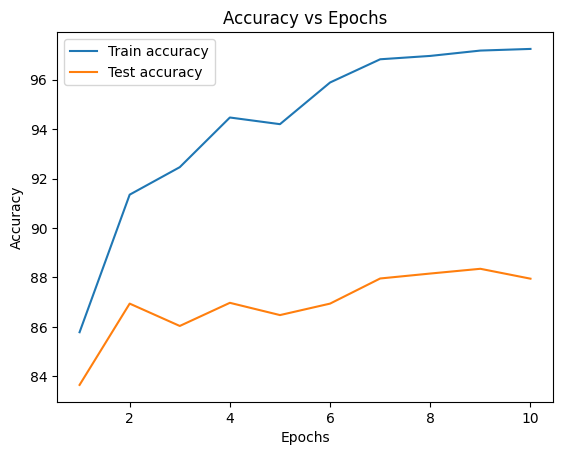

In [13]:
plt.plot(range(1, num_epochs+1), train_acc, label = "Train accuracy")
plt.plot(range(1, num_epochs+1), test_acc, label = "Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.show()